In [ ]:
print(1)

1


In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# k-Nearest Neighbor (kNN) exercise

*在提交作业时，请填写并提交此完整的工作表（包括其输出和工作表之外的任何辅助代码）。有关详细信息，请参阅 [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) 课程网站上。*

kNN 分类器由两个阶段组成：

- 在训练期间，分类器获取训练数据并简单记忆
- 在测试阶段，kNN 将每张测试图像与所有训练图像进行比较，并将最相似的 k 个训练实例的标签进行转移，从而对图像进行分类。
- k 值经过交叉验证

在本练习中，您将执行这些步骤，了解基本的图像分类流水线、交叉验证，并熟练编写高效的矢量化代码。

In [ ]:
#为本笔记本运行一些初始化代码。

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 这是一个让 matplotlib 图形在笔记本中内嵌显示的小魔法
# 而不是在新窗口中显示。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 再加点魔法，让笔记本重新加载外部 python 模块；
# 参见 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

In [ ]:
# 加载 CIFAR-10 原始数据。
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# 清理变量，防止多次加载数据（这可能会导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 为了检查是否正确，我们会打印出训练数据和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


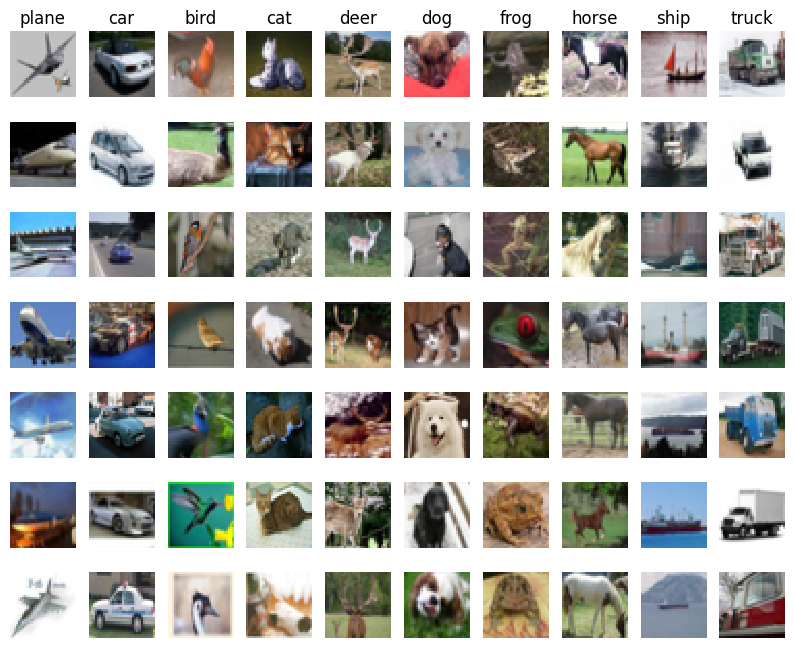

In [ ]:
# 可视化数据集中的一些示例。
# 我们展示了每个类别中的一些训练图像示例。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):#对于每一类
    idxs = np.flatnonzero(y_train == y)#所有样本中label为y的个数（实际上就是这类样本的个数）
    idxs = np.random.choice(idxs, samples_per_class, replace=False)#从0到idxs的样本中，随机抽samples_per_class个，不重复采样
    for i, idx in enumerate(idxs):#主要是画图
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# 在本练习中对数据进行子样本处理，以提高代码执行效率
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs231n.classifiers import KNearestNeighbor

# 创建 kNN 分类器实例
# 请记住，训练 kNN 分类器是一个不可能完成的任务：
# 分类器只需记住数据，无需进一步处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

现在，我们想用 kNN 分类器对测试数据进行分类。回顾一下，我们可以将这一过程分为两个步骤：

1. 首先，我们必须计算所有测试示例与所有训练示例之间的距离。
2. 根据这些距离，我们为每个测试示例找出 k 个最近的示例，并让它们为标签投票

首先，我们来计算所有训练和测试示例之间的距离矩阵。 比如如果有**Ntr** 个训练样本和 **Nte** 个测试样本, 这一阶段的结果应是 **Nte x Ntr** 的矩阵，其中，每个元素 (i,j) 是第 i 个测试样本和第 j 个训练样本之间的距离。

**注意：对于我们要求您在本笔记本中实现的三种距离计算，您可以不使用 numpy 提供的 np.linalg.norm() 函数。**

首先，打开 `cs231n/classifiers/k_nearest_neighbor.py`，并执行函数 `compute_distances_two_loops`，该函数使用（非常低效的）双循环遍历所有（测试、训练）示例对，每次计算一个元素的距离矩阵。

In [ ]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


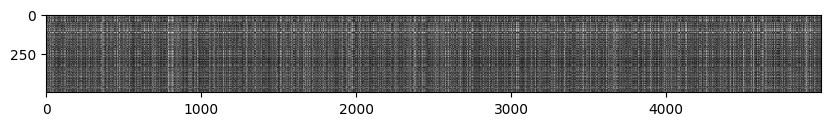

In [ ]:
# 我们可以直观地看到距离矩阵：每一行是一个测试示例和与训练实例的距离
plt.imshow(dists, interpolation='none')
plt.show()

**内联问题 1**

请注意距离矩阵中的结构模式，其中某些行或列明显更亮。(请注意，在默认配色方案中，黑色表示低距离，白色表示高距离）。

- 在数据中，是什么原因导致这些行明显变亮？
- 是什么导致了这些列？

$\color{blue}{\textit Your Answer:}$ 整行偏亮说明测试样本离群，整列偏亮说明训练样本离群，都是OOD的问题



In [ ]:
# 现在执行函数 predict_labels，并运行下面的代码：
# 我们使用 k = 1（即最近邻）。
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算并打印正确预测示例的比例
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


您预计会看到约`27%`的准确率。现在让我们尝试更大的`k`值，例如`k = 5`：

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


预计性能会比 `k = 1` 时稍好。

**内联问题2**

我们还可以使用其他距离度量，如 L1 距离。
对于某个图像 $I_k$ 中位置 $(i,j)$ 的像素值 $p_{ij}^{(k)}$、

所有图像中所有像素的平均值 $\mu$ 是 $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
所有图像的像素平均值 $\mu_{ij}$ 是
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
一般标准偏差 $\sigma$ 和像素标准偏差 $\sigma_{ij}$ 的定义类似。

以下哪些预处理步骤不会改变使用 L1 距离的近邻分类器的性能？请选择所有适用的步骤。说明一下，训练和测试示例的预处理方式相同。

1. 减去平均数 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. 减去每个像素的平均值 $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. 减去平均数 $\mu$ 再除以标准差 $\sigma$.
4. 减去像素平均值 $\mu_{ij}$，再除以像素标准偏 $\sigma_{ij}$。
5. 旋转数据坐标轴，即以相同角度旋转所有图像。旋转造成的图像空白区域将填充相同的像素值，不进行插值。

$\color{blue}{\textit Your Answer:}$1, 2 and 3


$\color{blue}{\textit Your Explanation:}$
1. 对于减去总体平均数：
   
   对于任意两幅图A，B，第i，j像素上的差
   $$\tilde{a}_{ij}​− \tilde{b}_{ij}​=(a_{ij}​−\mu)−(b_{ij}​−\mu)=a_{ij}​−b_{ij}​$$
   因此L1距离
   $$\sum_{ij}\vert \tilde{a}_{ij}​− \tilde{b}_{ij} \vert =\sum_{ij}\vert a_{ij}​−b_{ij}\vert $$
   结果完全一致

2. 对于减去每个像素的平均值：

   与第一问推导过程类似，只是把$\mu$换成了$\mu_{ij}$

3. 减去平均数$\mu$,再除以标准差$\sigma$：

   $$\tilde{a}_{ij}​− \tilde{b}_{ij}​=\frac{(a_{ij}​−\mu)}{\sigma}−\frac{(b_{ij}​−\mu)}{\sigma}=\frac{a_{ij}​−b_{ij}}{\sigma}​$$

   $$\sum_{ij}\vert\frac{ \tilde{a}_{ij}​− \tilde{b}_{ij}  }{\sigma}\vert=\frac{1}{\sigma}\sum_{ij}\vert a_{ij}​−b_{ij}\vert $$

   虽然绝对数值减少了，但是与相对大小不会改变，因此基于大小排序的预测结果不变。

4.
   两图像A,B 的 L1 距离变为加权和：
$$
\sum_{i, j}\vert\frac{a_{i j}-b_{i j}}{\sigma_{i j}}\vert=\sum_{i, j} w_{i j}\vert a_{i j}-b_{i j}\vert, \quad w_{i j}=\frac{1}{\sigma_{i j}}>0
$$
   这不是原 L1 距离的正比例变换，而是不同像素位置被不同权重重加权。这样的加权会改变样本间距离的相对大小，从而可能改变谁是最近邻。

5. 对于旋转坐标轴：
- 如果旋转只相当于坐标的排列（例如正好是 90°、180° 的像素网格置换），那么这只是重排像素索引——对 L1 距离来说是对和的顺序重排，距离值不变；kNN 不变。

- 但一般的任意角度旋转不是简单的像素置换（尤其非 90° 的角度）：旋转会把像素值混合或重新采样（即使不做插值，通常会进行最近邻采样或产生“新”的浮点值），这会改变像素向量在坐标系中的具体数值，进而改变 L1 距离。更根本地，L1 范数对正交旋转不具不变性。

In [ ]:
# 现在，让我们通过部分矢量化来加快距离矩阵的计算速度
# 只需一个循环。执行 compute_distances_one_loop 函数并运行
# 代码：
dists_one = classifier.compute_distances_one_loop(X_test)

# 为了确保我们的矢量化实现是正确的, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# 现在在 compute_distances_no_loops 内实现完全矢量化的版本
# 并运行代码
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查距离矩阵是否与我们之前计算的一致：
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# 让我们来比较一下执行速度有多快
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# 使用完全矢量化实现后，性能会明显提高！

# 注意：取决于您使用的机器、
# 从两个循环变为一个循环时，速度可能不会提高、
# 甚至可能会减慢.

Two loop version took 40.007601 seconds
One loop version took 53.562319 seconds
No loop version took 0.523553 seconds


### 交叉验证

我们采用了 k-近邻分类器，但任意设置了 k = 5。现在，我们将通过交叉验证来确定该超参数的最佳值。

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# 将训练数据划分为多个折叠. 拆分后，X_train_folds 和 y_train_folds 每个都应为         #
# 长度为num_folds 的列表,其中y_train_folds[i] 是 X_train_folds[i] 中点的标签向量。  #
# Hint: 查阅numpy的array_split函数。                                             #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# 存储交叉验证过程中不同k值对应准确率的字典。
# 交叉验证完成后，k_to_accuracies[k]应为长度为num_folds的列表，
# 其中每个元素表示使用该k值时获得的不同准确率值。

k_to_accuracies = {}


################################################################################
# TODO：                                                                        #
# 执行k折交叉验证以确定最佳k值。对于k的每个可能取值，运行k最近邻算法num_folds次          #
# 每次使用除最后一个折叠外的所有折叠作为训练数据，                                     #
# 将最后一个折叠作为验证集。将所有折叠和所有k值的准确率                                #
# 存储在k_to_accuracies字典中。                                                  #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = []   # 存每折的准确率
    for i in range(num_folds):
        # 验证集
        X_val = X_train_folds[i]
        y_val = y_train_folds[i]

        # 训练集 = 其他折拼接
        X_train_cv = np.vstack([X_train_folds[j] for j in range(num_folds) if j != i])
        y_train_cv = np.hstack([y_train_folds[j] for j in range(num_folds) if j != i])

        # 训练并预测
        classifier = KNearestNeighbor()
        classifier.train(X_train_cv, y_train_cv)
        y_val_pred = classifier.predict(X_val, k=k, num_loops=0)  # 默认用 no_loops

        # 计算准确率
        acc = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(acc)


# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

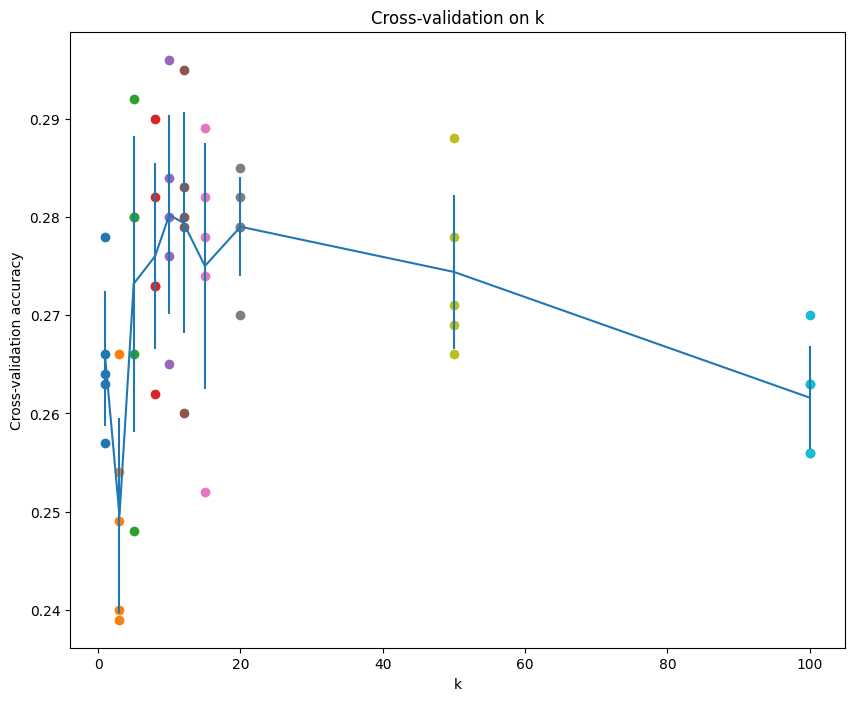

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# 根据上述交叉验证结果，选择最佳k值，
# 使用全部训练数据重新训练分类器，并在测试数据上进行验证。
# 您应能在测试数据上获得高于28%的准确率。
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

在分类场景中，关于$k$最近邻（$k$-NN）的下列陈述哪些在所有$k$值下都成立？请选择所有正确的选项。
1. $k$最近邻分类器的决策边界是线性的。
2. 1-NN的训练误差永远小于或等于5-NN的训练误差。
3. 1-NN的测试误差永远小于5-NN的测试误差。
4. 使用k-NN分类器对测试样本进行分类所需的时间随训练集规模增长而增加。
5. 以上皆非。

$\color{blue}{\textit Your Answer:}$4


$\color{blue}{\textit Your Explanation:}$
1. 错，k-NN 的决策边界一般是高度非线性的，由训练点多数投票的复杂边界决定。
2. 错，上面的训练结果中已经有反例了。
3. 错，测试误差受偏差—方差权衡影响：1-NN 方差高（容易过拟合噪声），较大的 k常常降低方差、提高泛化，因此 5-NN 在测试集上有时明显优于 1-NN。没有“对所有数据集都成立”的关系。
4. 对的，典型的 k-NN 实现需要对每个测试点计算到所有训练点的距离，所以时间复杂度随着训练样本数线性增长。
5. 错。

